In [229]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, \
              recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score, \
              auc, mean_squared_error

In [210]:
def trans_1(df):

    df['International plan'] = df['International plan'].map({'No':0, 'Yes':1})
    df['Voice mail plan'] = df['Voice mail plan'].map({'No':0, 'Yes':1})
    
    df['charge'] = df['Total day charge'] + df['Total eve charge'] + \
                       df['Total night charge'] + df['Total intl charge']
    
    df['calls'] = df['Total day calls'] + df['Total eve calls'] + \
                       df['Total night calls'] + df['Total intl calls']
    

    X = df.drop(['State', 'Account length', 'Area code' , 'Churn', 
             'Total day minutes', 'Total eve minutes','Total night minutes', 'Total intl minutes',
             'Total day calls', 'Total eve calls','Total night calls', 'Total intl calls',
             'Total day charge','Total eve charge','Total night charge', 'Total intl charge'], axis = 1)
    
    Y = df['Churn']
    
    return X, Y


def trans_2(df):

    df['International plan'] = df['International plan'].map({'No':0, 'Yes':1})
    df['Voice mail plan'] = df['Voice mail plan'].map({'No':0, 'Yes':1})
    
#    df['charge'] = df['Total day charge'] + df['Total eve charge'] + \
#                       df['Total night charge'] + df['Total intl charge']
    

    X = df.drop(['State', 'Account length', 'Area code' , 'Churn'], axis = 1)
    
    Y = df['Churn']
    
    return X, Y


In [4]:
df = pd.read_csv('churn-bigml-80.csv')

In [5]:
df['International plan'] = df['International plan'].map({'No':0, 'Yes':1})
df['Voice mail plan'] = df['Voice mail plan'].map({'No':0, 'Yes':1})
X = df.drop(['State', 'Account length', 'Area code'], axis = 1)


In [6]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state = 2589)

In [7]:
embedding = tsne.fit_transform(X)

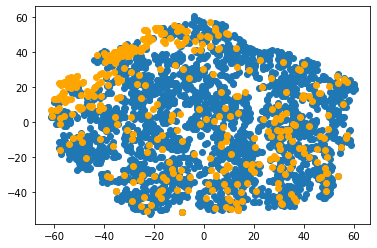

In [8]:
plt.scatter(embedding[~df.Churn,0], embedding[~df.Churn,1] )
plt.scatter(embedding[df.Churn,0], embedding[df.Churn,1], color = 'orange')

# 1. Классификация
(обучение с учителем, количество классов, пакетное/динамическое)

In [211]:
df = pd.read_csv('churn-bigml-80.csv')
test_df = pd.read_csv('churn-bigml-20.csv')

In [212]:
# импорт функций преобразования данных
# import trans.ipynb as tr

In [213]:
X,Y = trans_2(df)
X_test,Y_test = trans_2(test_df)

### Дерево решений

In [214]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()

In [215]:
clf.fit(X,Y)

DecisionTreeClassifier()

In [216]:
clf.score(X,Y)

1.0

In [217]:
clf.score(X_test,Y_test)

0.9220389805097451

### Стохастический поиск

In [218]:
from sklearn.linear_model import SGDClassifier
SGDclf = SGDClassifier(random_state=42)
# random_state=42, надо чтобы зафиксировать значения,иначе они немного меняются

In [219]:
SGDclf.fit(X,Y)

SGDClassifier(random_state=42)

In [220]:
SGDclf.score(X_test,Y_test), SGDclf.score(X,Y)

(0.8575712143928036, 0.854463615903976)

In [221]:
pred = SGDclf.predict(X_test)

In [222]:
precision_score(Y_test, pred), recall_score(Y_test, pred)

C:\Users\laptop\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.0, 0.0)

In [223]:
confusion_matrix(Y_test,pred) 

array([[572,   0],
       [ 95,   0]], dtype=int64)

### Адаптивный бустинг

In [224]:
from sklearn.ensemble import AdaBoostClassifier

In [136]:
Ada_clf = AdaBoostClassifier(base_estimator = tree.DecisionTreeClassifier(max_depth = 2))

In [137]:
Ada_clf.fit(X,Y)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2))

In [138]:
Ada_clf.score(X_test,Y_test), Ada_clf.score(X,Y)

(0.9385307346326837, 0.9741185296324081)

In [139]:
pred = Ada_clf.predict(X_test)

In [140]:
confusion_matrix(Y_test,pred)


array([[556,  16],
       [ 25,  70]], dtype=int64)

In [141]:
precision_score(Y_test,pred), recall_score(Y_test,pred), f1_score(Y_test,pred) 

(0.813953488372093, 0.7368421052631579, 0.7734806629834253)

In [156]:
Y_score = Ada_clf.decision_function(X)

### Функция решения

In [142]:
Y_score = SGDclf.decision_function(X)
pred = SGDclf.predict(X)

In [143]:
Y_score

array([1333.38977639, -628.3515251 , 1403.11286037, ..., 3035.12906555,
        322.86205285,   33.4594491 ])

In [144]:
Y_score.shape

(2666,)

In [145]:
# мы фиксируем максим. и миним.значения у decision_function(X)
ma = Y_score.max() 
mi = Y_score.min()

In [146]:
ma, mi

(5296.005502104156, -5531.736476537662)

Получаем прогноз с помощью сравнения с барьером

In [147]:
predict = Y_score > 0

In [148]:
precision_score(Y, predict), recall_score(Y, predict)

(0.20724346076458752, 0.7963917525773195)

In [149]:
confusion_matrix(Y,predict)

array([[1096, 1182],
       [  79,  309]], dtype=int64)

In [158]:
#функция возвращает для разных значений порога значение точности и полноты
pre, rec, trans_2 = precision_recall_curve(Y, Y_score)

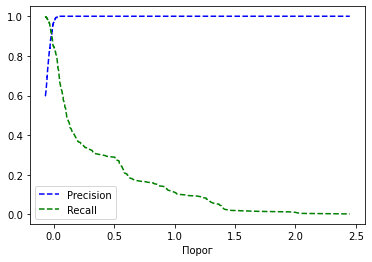

In [159]:
plt.plot(trans_2, pre[:-1], 'b--', label = 'Precision')
plt.plot(trans_2, rec[:-1], 'g--', label = 'Recall')
plt.xlabel('Порог')
plt.legend()
#
#


In [160]:
trans_2

array([-6.99229779e-02, -6.95424466e-02, -6.95336596e-02, -6.94848871e-02,
       -6.92141207e-02, -6.91810495e-02, -6.91774324e-02, -6.90751835e-02,
       -6.88928111e-02, -6.87884518e-02, -6.84194469e-02, -6.82175634e-02,
       -6.79252118e-02, -6.77718267e-02, -6.75422836e-02, -6.73380972e-02,
       -6.72893630e-02, -6.72254654e-02, -6.66555294e-02, -6.64608104e-02,
       -6.62639492e-02, -6.61734387e-02, -6.57572153e-02, -6.57062362e-02,
       -6.55296017e-02, -6.53452333e-02, -6.51943757e-02, -6.50852128e-02,
       -6.50655115e-02, -6.50300142e-02, -6.49192614e-02, -6.47053670e-02,
       -6.45953688e-02, -6.43455718e-02, -6.43139055e-02, -6.41836161e-02,
       -6.38960228e-02, -6.36432826e-02, -6.34430205e-02, -6.32627627e-02,
       -6.31675691e-02, -6.30547989e-02, -6.29635361e-02, -6.27946574e-02,
       -6.26092034e-02, -6.25810419e-02, -6.23273698e-02, -6.20413825e-02,
       -6.19571246e-02, -6.18162689e-02, -6.16525934e-02, -6.16292074e-02,
       -6.12055862e-02, -

Text(0, 0.5, 'Точность')

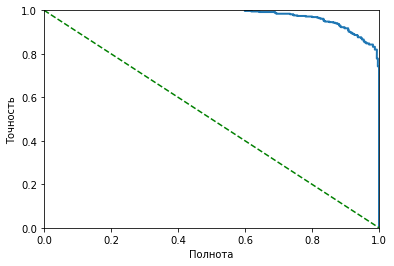

In [161]:
# переформатируем рисование - данные те же
plt.plot(pre, rec, linewidth = 2)
plt.plot([0,1], [1,0], 'g--')
plt.axis([0,1,0,1])
plt.xlabel('Полнота')
plt.ylabel('Точность')

In [162]:
fpr, tpr, trans_2 = roc_curve(Y, Y_score)

Text(0, 0.5, 'True Positive Rate')

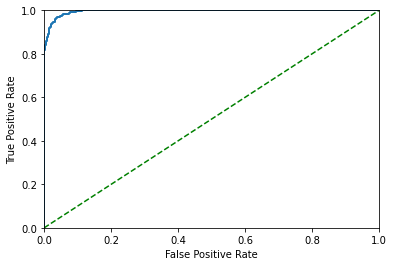

In [163]:
plt.plot(fpr, tpr, linewidth = 2)
plt.plot([0,1], [0,1], 'g--')
plt.axis([0,1,0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [164]:
pred = SGDclf.predict(X)
roc_auc_score (Y, pred)

0.6387577726890109

In [165]:
pred = Ada_clf.predict(X)
roc_auc_score (Y, pred)

0.9217741643510766

# Многоклассовая классификация

In [167]:
from sklearn.datasets import load_iris

In [168]:
iris = load_iris()

In [169]:
# это словарь
iris

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

In [170]:
iris.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename'])

In [171]:
X = iris.data
Y = iris.target

In [172]:
X

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3

In [173]:
Y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [174]:
Y.shape

(150,)

In [175]:
SGDclf.fit(X,Y)

SGDClassifier(random_state=42)

In [176]:
SGDclf.score(X,Y)

0.9333333333333333

In [177]:
pred = SGDclf.predict(X)

In [182]:
# по столбцам прогнозные значения, по строкам фактические значения.
cm = confusion_matrix(Y, pred)
cm

array([[50,  0,  0],
       [ 2, 46,  2],
       [ 0,  6, 44]], dtype=int64)

<AxesSubplot:>

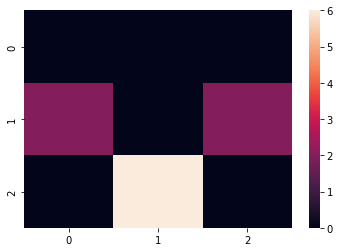

In [185]:
sns.heatmap(cm)

In [ ]:
В случае с несколькими классами и несколькими метками это средний балл F1 каждого класса с взвешиванием, зависящим от average параметра.

In [186]:
# макро - считает метрики для каждой метки и берет среднее значение. 
precision_score(Y,pred, average = 'macro'), recall_score(Y,pred, average = 'macro'), f1_score(Y,pred, average = 'macro') 

(0.9342251950947604, 0.9333333333333332, 0.9330065359477123)

In [184]:
#заполняем диагональную матрицу нулями
cm[0,0] = cm[1,1] = cm[2,2] = 0 # подсветка ошибок

### OvR

In [187]:
SGDclf.decision_function([X[149]])

array([[-103.42193738,  -42.10406774,   34.8362185 ]])

### OvO

In [189]:
from sklearn.multiclass import OneVsOneClassifier 

In [190]:
ovoSGD = OneVsOneClassifier(SGDClassifier(random_state = 42))
ovoSGD.fit(X,Y)

OneVsOneClassifier(estimator=SGDClassifier(random_state=42))

In [191]:
ovoSGD.decision_function([X[149]])

array([[-0.3319726 ,  1.32548314,  2.33169537]])

In [192]:
ovoSGD.predict([X[149]])

array([2])

In [193]:
ovoSGD.estimators_

(SGDClassifier(random_state=42),
 SGDClassifier(random_state=42),
 SGDClassifier(random_state=42))

# Регрессия и регуляризация

In [225]:
from sklearn.linear_model import SGDRegressor

In [226]:
# генерируем данные
X = 2*np.linspace(0,2,100)
y = 2.5+(3*X).reshape(-1,1) + 2.5*np.random.rand(100,1) # шум
#y = 2.5+3*X[:,0]*X[:,0] + np.random.randn(100,1) # шум
X_b = np.c_[np.ones((100,1)),X]  
y = y.reshape(100)

X1 = 2*np.linspace(0,2,30)
y1 = 2.7+(3*X1).reshape(-1,1) + .5*np.random.randn(30,1) # шум
#y = 2.5+3*X[:,0]*X[:,0] + np.random.randn(100,1) # шум
y1 = y1.reshape(30)


In [227]:
X_train, X_test = X, X1 
Y_train,  Y_test =  y, y1

In [234]:
import math
SGDR = SGDRegressor(penalty='l2',alpha = 0.5)
SGDR.fit(X_train.reshape(-1,1), Y_train)
preds = SGDR.predict(X_test.reshape(-1,1))
mse = mean_squared_error(Y_test, preds)
rmse_test = math.sqrt(mse)

preds = SGDR.predict(X_train.reshape(-1,1))
mse = mean_squared_error(Y_train, preds)
rmse_train = math.sqrt(mse)

rmse_train, rmse_test

(0.9107921796294466, 0.9859164746450249)

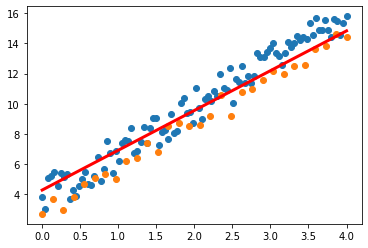

In [235]:
plt.scatter(X,y)
plt.scatter(X1,y1)
plt.plot(X_test, SGDR.predict(X_test.reshape(-1,1)), color = 'red', linewidth = 3)

In [236]:
SGDR.coef_ , SGDR.intercept_

(array([2.63523231]), array([4.28345856]))

## Логистическая регрессия

In [237]:
import math

In [238]:
x = np.linspace(-7,7, 100)
y = np.linspace(-2,2, 100)
v = np.linspace(-2,2, 100)
for i in range(100):
    y[i] = 1/(1+math.exp(-x[i]))
    v[i] = 0.5


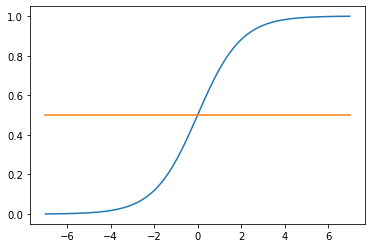

In [239]:
plt.plot(x,y)
plt.plot(x,v)

In [506]:
x = np.linspace(0.001, 1, 100)
y = np.linspace(0.001, 1, 100)

for i in range(100):
    y[i] = - math.log(x[i])


In [508]:
#plt.plot(x,y)

In [493]:
X = iris['data'][:,3:]
y = (iris['target'] == 2).astype(np.int32)

In [510]:
# оценить X, Y

In [494]:
from sklearn.linear_model import LogisticRegression 
logReg = LogisticRegression()

In [495]:
logReg.fit(X,y)

LogisticRegression()

In [511]:
#Xnew = np.linspace(0, 3, 1000).reshape(-1,1)
#y_proba = logReg.predict_proba(Xnew)
#plt.plot(Xnew, y_proba[:,1], 'g-', label = 'Ирис Вирнинский')
#plt.plot(Xnew, y_proba[:,0], 'b--', label = 'не Ирис Вирнинский');

In [ ]:
# граница уверенных решений менее 1 и более 2,
# внутри интервала классификатор менее уверен